# How to transform between various macaque MRI templates

**Authors:** Nikoloz Sirmpilatze (NSirmpilatze@dpz.eu) & Chris Klink (c.klink@nin.knaw.nl)

**Last updated:** 16 Feb 2020

**Requirements:**
1. Using the command line
    * _ANTs_ >= 2.1.0
        * _antsApplyTransforms_ needs to be in your path as executable
2. Using the nipype interface
    * _ANTs_ >= 2.1.0
        * _antsApplyTransforms_ needs to be in your path as executable
    * _python_ >= 3.7
    * _nipype_ >= 1.2.0
    
PS: if you have older versions of ANTs or python on your system, make sure to still give it a try. There is a high chance that it will work. It's just not tested.

Warps are provided for transformations between the following templates
1. [NMT v1.2](https://github.com/jms290/NMT)
2. [NMT v1.3](https://github.com/jms290/NMT)
3. [D99](https://afni.nimh.nih.gov/Macaque)
4. [INIA19](https://www.nitrc.org/projects/inia19/https://www.nitrc.org/projects/inia19/)
5. [MNI macaque](http://www.bic.mni.mcgill.ca/ServicesAtlases/Macaque)
6. [Yerkes19](https://github.com/Washington-University/NHPPipelines)

Within this notebook, they are abbreviated as *NMTv12*, *NMTv13*, *D99*, *INIA*, *MNI*, and *YRK*  

There are 30 warps in total (15 unique template pairs, with 2 directions per pair). The naming of the warps follows the scheme: 
* InputAbbrev_to_OutputAbbrev_CompositeWarp.nii.gz
For example:
* NMTv12_to_D99_CompositeWarp.nii.gz

The 'Composite' refers to the fact that this warp combines information from a linear *affine* transform and a non-linear *SyN* transform.

The code in this notebook also requires the template brain files. We do not provide copies of these templates (licenses often forbids redistribution), but you follow the links above and download them at the source. We do offer the warp files that will be produced by this workflow. They can be downloaded from Zenodo (DOI:10.5281/zenodo.3668510).    

IN our version of this code the template folders are set up as follows:    

|--- RheMAP   
&emsp; |--- notebooks     
&emsp; |--- templates     
&emsp; &emsp; |--- D99     
&emsp; &emsp; &emsp; |--- D99_atlas_1.2a.nii.gz     
&emsp; &emsp; &emsp; |--- D99_atlas_1.2a_in_MNI.nii.gz     
&emsp; &emsp; &emsp; |--- D99_template.nii.gz      
&emsp; &emsp; |--- INIA   
&emsp; &emsp; &emsp; |--- inia19-t1-brain_truncated.nii.gz      
&emsp; &emsp; |--- MNI     
&emsp; &emsp; &emsp; |--- macaque_25_model-MNI_brain.nii.gz      
&emsp; &emsp; |--- NMT     
&emsp; &emsp; &emsp; |--- NMT_v1.2     
&emsp; &emsp; &emsp; &emsp; |--- NMT_SS.nii.gz      
&emsp; &emsp; &emsp; |--- NMT_v1.3     
&emsp; &emsp; &emsp; &emsp; |--- NMT_SS.nii.gz     
&emsp; &emsp; |--- YRK      
&emsp; &emsp; &emsp; |--- MacaqueYerkes19_T1w_0.5mm_brain.nii.gz       


## Import libraries

In [ ]:
import time
import os
import nipype.interfaces.ants as ants # nipype interface for ANTs
from nilearn.plotting import plot_roi, plot_stat_map #for visualization only

## Example 1: Transforming an atlas (parcellation) 
Let's take the D99 atlas and transform it from [D99](https://afni.nimh.nih.gov/Macaque) space to [MNI macaque](http://www.bic.mni.mcgill.ca/ServicesAtlases/Macaque) space

First let's define relative paths to the necessary files.

**You need to change these depending on where they are stored on your system.**

In [2]:
# ================================================================
# NB! Specific for each individiual system 
# This is the only cell where you should need to alter anything
# ================================================================

# NS -----
# templates_path = '/home/nsirmpilatze/home@dpz/templates/'
# warps_path = '/home/nsirmpilatze/home@dpz/templates/'
# data_path = '/home/nsirmpilatze/home@dpz/templates/'
# output_path = '/home/nsirmpilatze/home@dpz/templates/'

# D99_path = templates_path + 'D99/'
# MNI_path = templates_path + 'MNI_macaque/'
# NMT_path = templates_path + 'NMT/NMT_v1.2/'


# CK -----
base_path      =  '/home/chris/Documents/PRIME-RE/RheMAP/'
templates_path = base_path + 'templates/'
warps_path     = base_path + 'warps/composite/' # check with the existing warps
data_path      = base_path + 'example_data/'
output_path    = base_path + 'output/'

D99_path = templates_path + 'D99/'
MNI_path = templates_path + 'MNI/'
NMTv12_path = templates_path + 'NMT/NMT_v1.2/'

D99_brain = D99_path + 'D99_template.nii.gz'
MNI_brain = MNI_path + 'macaque_25_model-MNI_brain.nii.gz'
NMTv12_brain = NMTv12_path + 'NMT_SS.nii.gz'

D99_atlas = D99_path + 'D99_atlas_1.2a.nii.gz'

In [3]:
# The name of the output file
D99_atlas_in_MNI = output_path + 'D99_atlas_1.2a_in_MNI.nii.gz'

# Full (affine + SyN) composite warp 
warp_D99_to_MNI = warps_path + 'D99_to_MNI_CompositeWarp.nii.gz'

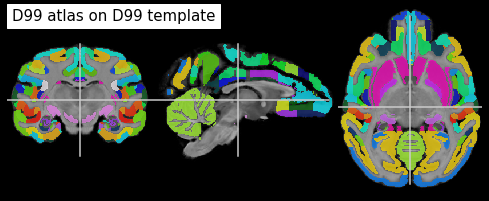

In [4]:
plot_roi(D99_atlas, bg_img=D99_brain, annotate=False,
        title='D99 atlas on D99 template');

### Option a: using antsApplyTransforms through the command line

Command:
```bash
antsApplyTransforms -i $D99_atlas -r $MNI_brain -o $D99_atlas_in_MNI 
-t $warp -n NearestNeighbor
```
Let's explain the arguments, which are passed through flags:
* -i: input image
* -r: reference image (target space)
* -o: output image
* -t: transform 
* -n: interpolation
    * The default is _Linear_, but here we set it to _NearestNeighbor_. Since the parcellation is defined with discrete numerical values, this ensures that we won't end up with any intermediate numbers in the output image

Let's give this a try

In [5]:
!antsApplyTransforms -i $D99_atlas -r $MNI_brain -o $D99_atlas_in_MNI -t $warp_D99_to_MNI -n NearestNeighbor

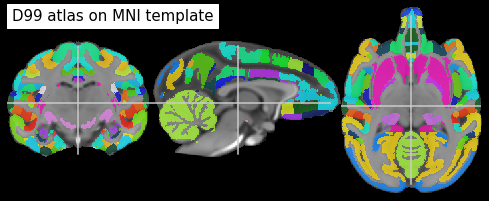

In [6]:
plot_roi(D99_atlas_in_MNI, bg_img=MNI_brain, annotate=False, dim=-0.5,
        title='D99 atlas on MNI template');

### Option b: using the nipype interface for antsApplyTransforms
[Read the nipype documentation here](https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/resampling.html#applytransforms)

In [7]:
apply_warp = ants.ApplyTransforms(
                input_image=D99_atlas,
                reference_image=MNI_brain,
                output_image=D99_atlas_in_MNI,
                transforms=warp_D99_to_MNI,
                interpolation='NearestNeighbor')
apply_warp.run();

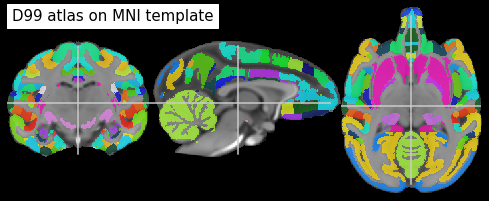

In [8]:
plot_roi(D99_atlas_in_MNI, bg_img=MNI_brain, annotate=False, dim=-0.5,
        title='D99 atlas on MNI template');

The results with both options should be identical

## Example 2: Transforming a statistical map

Let's transform an example statistical map from from [NMT](https://github.com/jms290/NMT) space to [D99](https://afni.nimh.nih.gov/Macaque) space

In [9]:
stat_map_in_NMTv12 = data_path + 'example_stat_map_in_NMTv1.2.nii.gz'
# The name of the output file
stat_map_in_D99 = output_path + 'example_stat_map_in_D99.nii.gz'
# Full (affine + SyN) composite warp 
warp_NMTv12_to_D99 = warps_path + 'NMTv1.2_to_D99_CompositeWarp.nii.gz'

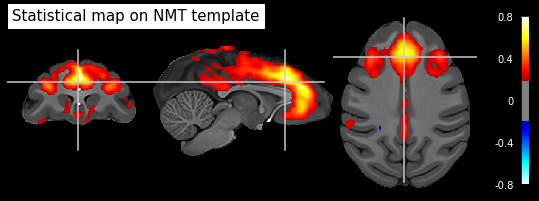

In [10]:
plot_stat_map(stat_map_in_NMTv12, bg_img=NMTv12_brain, annotate=False,
              threshold= 0.2, vmax=0.8, dim=-1,
              title='Statistical map on NMT template');

### Option a: using antsApplyTransforms through the command line

Notice that this time we use _Linear_ interpolation. More advanced interpolation options are also available (e.g. 'BSpline'). 

In [11]:
!antsApplyTransforms -i $stat_map_in_NMTv12 -r $D99_brain -o $stat_map_in_D99 -t $warp_NMTv12_to_D99 -n Linear

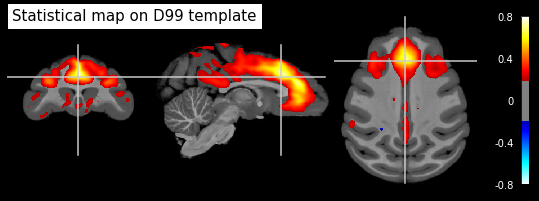

In [12]:
plot_stat_map(stat_map_in_D99, bg_img=D99_brain, annotate=False,
              threshold= 0.2, vmax=0.8,
              title='Statistical map on D99 template');

### Option b: using the nipype interface for antsApplyTransforms
[Read the documentation here](https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/resampling.html#applytransforms)

In [13]:
apply_warp = ants.ApplyTransforms(
                input_image=stat_map_in_NMTv12,
                reference_image=D99_brain,
                output_image=stat_map_in_D99,
                transforms=warp_NMTv12_to_D99,
                interpolation='Linear')
apply_warp.run();

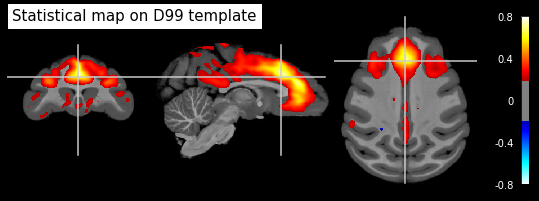

In [14]:
plot_stat_map(stat_map_in_D99, bg_img=D99_brain, annotate=False,
              threshold= 0.2, vmax=0.8,
              title='Statistical map on D99 template');